In [3]:
import numpy as np
import pylab as plt
nt = 200
natom = 864
L = 10.229
Sigma = 3.4
m = 39.95 * 1.67 *10**(-24)  #g
kb = 1.38 * 10**(-16)  # erg/K
epsilon = 120 * kb  # erg
t = np.zeros((nt))
x = np.zeros((natom, 3, nt))
v = np.zeros((natom, 3, nt))

Open and read the Data file, the variable saved will be position (x) and velocity (v), the first axis is index of atom, the second is %the direction, the third is time step. Format:
$$x[n = (0,1,2,...),direction (x,y,z), time( ex: 0.1,0.2)] = avlue$$
$$v[n = (0,1,2,...),direction (x,y,z), time( ex: 0.1,0.2)] = avlue$$

In [4]:
with open("Output.lammpstrj") as f:
    for i in range(nt):
        dummy = f.readline()
        t[i] = f.readline()
        for d in range(7):
            dummy = f.readline()
        for j in range(natom):
            dummy = f.readline()
            line = dummy.split()
            for k in range(3):
                x[j, k, i] = float(line[k + 1])
                v[j, k, i] = float(line[k + 4])

In [5]:
def Boltdistribution(vp, Tp):
    return (4 * np.pi) / (2 * np.pi)**(3/2) * vp**2 * (120 / Tp)**(3/2) * np.exp(-120 * vp**2 / (2 * Tp))
#def Boltxdistribution(vp, Tp):
    

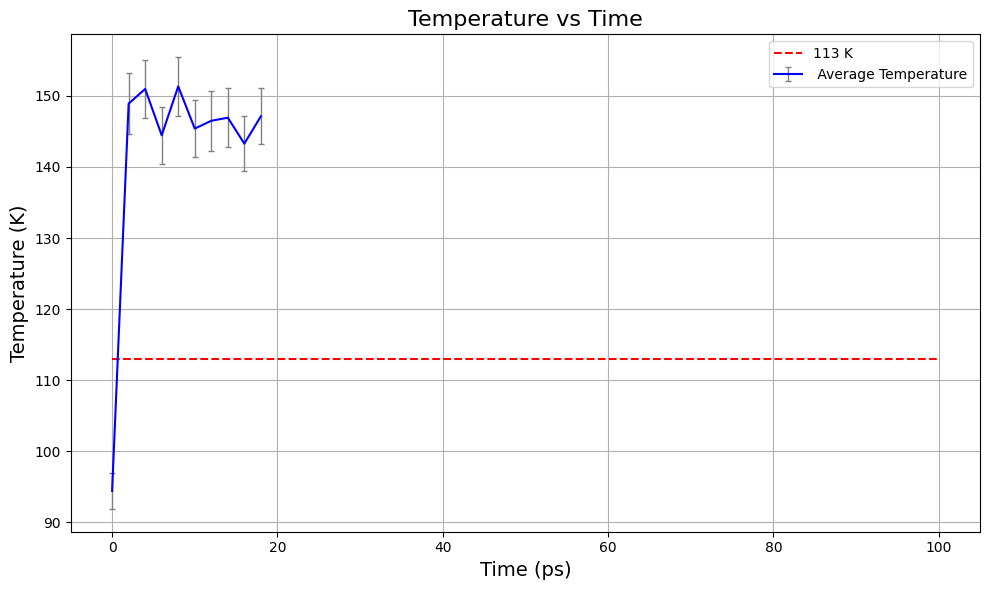

In [6]:

v_squared = np.sum(v**2, axis=1)  
v_squared *= (epsilon / m) 
kinetic_energy = 0.5 * m * v_squared

# Calculate the temperature
temperature_recalculated = (2 / 3) * (kinetic_energy / kb)

# Calculate the mean and standard deviation of the temperature
temperature_mean = np.mean(temperature_recalculated, axis=0)
temperature_std = np.std(temperature_recalculated, axis=0)/np.sqrt(natom)

# Plot the recalculated temperature with error bars
time_steps = np.arange(nt) * 0.1  # Assuming time step is 0.1 ps
plt.figure(figsize=(10, 6))
plt.errorbar(time_steps[::20], temperature_mean[::20], yerr=temperature_std[::20], fmt='b-', ecolor='gray', elinewidth=1, capsize=2, label=' Average Temperature')
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Temperature (K)', fontsize=14)
plt.hlines(113, 0, 100, colors='r', linestyles='dashed', label='113 K')
plt.title('Temperature vs Time', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('temperature_vs_time.pdf', format='pdf')

Using the lammpstrj format, I can extract the position and velocity of the particles at various time step. The plot of velocity on any direction expected to have the Gaussian which the mean value at 0. And the histogram of total speed expected to have the Boltzman distribution shape.

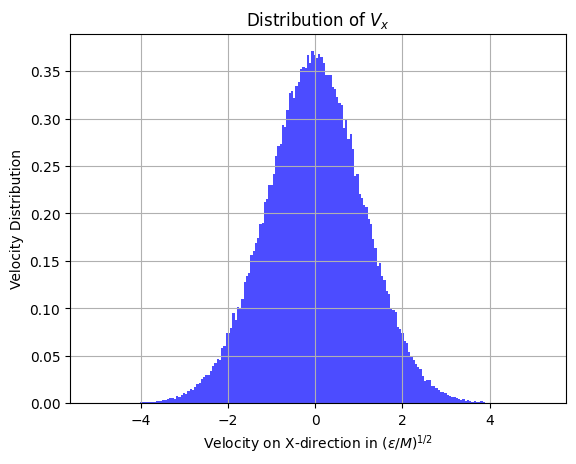

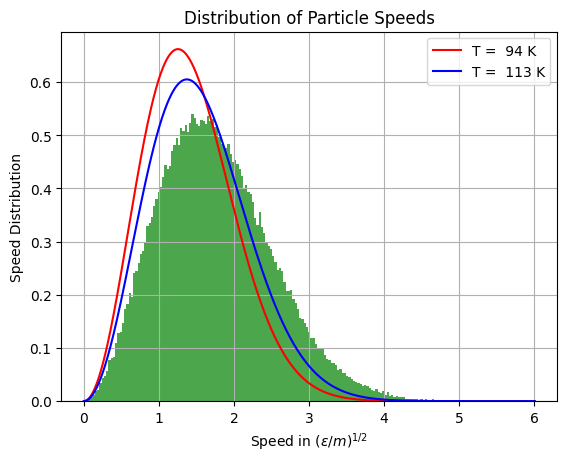

In [7]:
vx_combined = v[ :, 0, :].flatten() # Flatten to combine all time steps
# Plot histogram of vx
plt.grid(True)
plt.hist(vx_combined, bins=200, alpha=0.7, color='blue', density=True)
plt.xlabel(r'Velocity on X-direction in $(\epsilon/M)^{1/2}$')
plt.ylabel(r'Velocity Distribution')
plt.title('Distribution of $V_x$')
plt.show()
# Plot histogram of speeds
# Calculate the speed of each particle as the magnitude of the velocity vector at all time steps
speed = np.linalg.norm(v, axis=1).flatten()  # Flatten to combine all time steps
vp = np.linspace(0, np.max(speed), 1000)
Tp = [94.4,113]  # Example temperature in Kelvin
fv = Boltdistribution(vp, Tp[0])
plt.plot(vp,fv, 'r-', label='T = % d K' % Tp[0])
fv = Boltdistribution(vp, Tp[1])
plt.plot(vp,fv, 'b-', label='T = % d K' % Tp[1])
plt.hist(speed, bins=200, alpha=0.7, color='green', density=True)
plt.grid(True)
plt.xlabel(r'Speed in $(\epsilon/m)^{1/2}$')
plt.ylabel(r'Speed Distribution')
plt.title('Distribution of Particle Speeds')
# Save the figure to a PDF file
plt.legend()
plt.savefig("velocity_distribution.pdf", format="pdf")

As we can see, the Distribution have the form of the Gaussian and Maxwell distribution (match with the Distribution line ($T\approx 112 K$)). Since we are working with Leonard-John potential, the particles will have a relative distance between them in the form of the shell, we can plot it as:

In [21]:
# Calculate g(r) and its standard deviation over multiple time steps
def average_pair_correlation_with_error(x, box_length, time_steps=1, nbins=100):
    """
    Calculate the average pair correlation function and its standard deviation over multiple time steps.
    
    Parameters:
    x (numpy.ndarray): Positions of atoms for all time steps, shape (natom, 3, nt)
    box_length (float): Length of the simulation box
    time_steps (int): Number of time steps to use for averaging
    nbins (int): Number of bins for histogram
    
    Returns:
    r (numpy.ndarray): Radial distance values
    g_r_avg (numpy.ndarray): Average pair correlation function values
    g_r_std (numpy.ndarray): Standard deviation of g(r) values
    """
    natom, _, nt = x.shape
    
    # Use equally spaced time steps for averaging
    step = nt // time_steps
    selected_times = np.arange(0, nt, step)[:time_steps]
    
    # Create bins for the histogram
    r_max = box_length / 2.0
    bins = np.linspace(0, r_max, nbins + 1)
    r = 0.5 * (bins[1:] + bins[:-1])  # Centers of bins
    dr = bins[1] - bins[0]  # Bin width
    
    # Initialize arrays
    g_r_values = np.zeros((time_steps, nbins))
    
    # Calculate g(r) for each selected time step
    for t_idx in range(len(selected_times)):
        positions = x[:, :, selected_times[t_idx]]
        hist = np.zeros(nbins)
        
        # Calculate all pairwise distances considering periodic boundary conditions
        for i in range(natom):
            for j in range(i + 1, natom):
                dx = positions[i, 0] - positions[j, 0]
                dy = positions[i, 1] - positions[j, 1]
                dz = positions[i, 2] - positions[j, 2]
                
                # Apply minimum image convention
                dx -= box_length * np.round(dx / box_length)
                dy -= box_length * np.round(dy / box_length)
                dz -= box_length * np.round(dz / box_length)
                
                # Calculate distance
                r_ij = np.sqrt(dx**2 + dy**2 + dz**2)
                
                # Add to histogram if within range
                if r_ij < r_max:
                    bin_index = int(r_ij / dr)
                    if bin_index < nbins:
                        hist[bin_index] += 2  # Count each pair twice (i->j and j->i)
        
        # Normalize histogram to get g(r)
        shell_volume = 4.0 * np.pi * r**2 * dr
        number_density = natom / (box_length**3)
        ideal_count = number_density * shell_volume
        g_r_values[t_idx, :] = hist / (natom * ideal_count)
    
    # Calculate average and standard deviation
    
    return r,  g_r_values

# Calculate g(r) with error bars
r, g_r_values = average_pair_correlation_with_error(x, L, time_steps=100, nbins=150)


15000


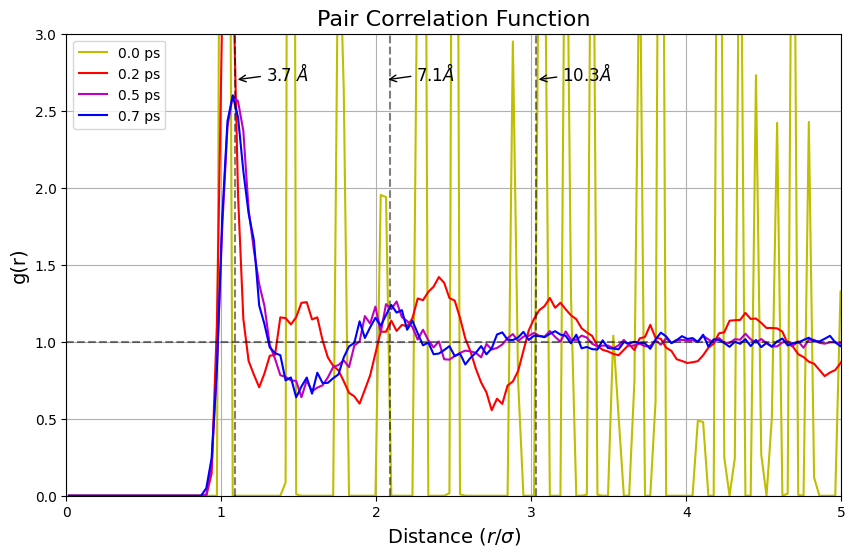

In [ ]:
# Plot g(r) with error bars
print(np.size(g_r_values))
plt.figure(figsize=(10, 6))
plt.plot(r, g_r_values[0,:], 'y-', label='0.0 ps')
plt.plot(r, g_r_values[2,:], 'r-', label='0.2 ps')
plt.plot(r, g_r_values[5,:], 'm-', label='0.5 ps')
plt.plot(r, g_r_values[7,:], 'b-', label='0.7 ps')
plt.xlabel(r'Distance $(r/\sigma)$', fontsize=14)
plt.ylabel('g(r)', fontsize=14)
plt.title('The Pair Correlation Function', fontsize=16)
plt.grid(True)
plt.vlines(x=3.7/Sigma, color='k', linestyle='--', alpha=0.5, ymin=0, ymax=5)
plt.vlines(x=(7.1/Sigma), color='k', linestyle='--', alpha=0.5, ymin=0, ymax=5)
plt.vlines(x=(10.3/Sigma), color='k', linestyle='--', alpha=0.5, ymin=0, ymax=5)
plt.annotate(r'3.7 $\AA$', xy=(3.7/Sigma, 2.7), xytext=(3.7/Sigma + 0.2, 2.7),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='black')
plt.annotate(r'7.1$\AA$', xy=(7.0/Sigma, 2.7), xytext=(7.0/Sigma + 0.2, 2.7),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='black')
plt.annotate(r'10.3$\AA$', xy=(10.3/Sigma, 2.7), xytext=(10.2/Sigma + 0.2, 2.7),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='black')
plt.xlim(0, min(5, L/2))
plt.ylim(0, 3)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.savefig("pair_correlation_function_with_error.pdf", format="pdf")
plt.show()

As shown in the figure, the pair correlation between the particles have the peak at the corresponding distant 3.7,7.1, 10.2 Angstrong

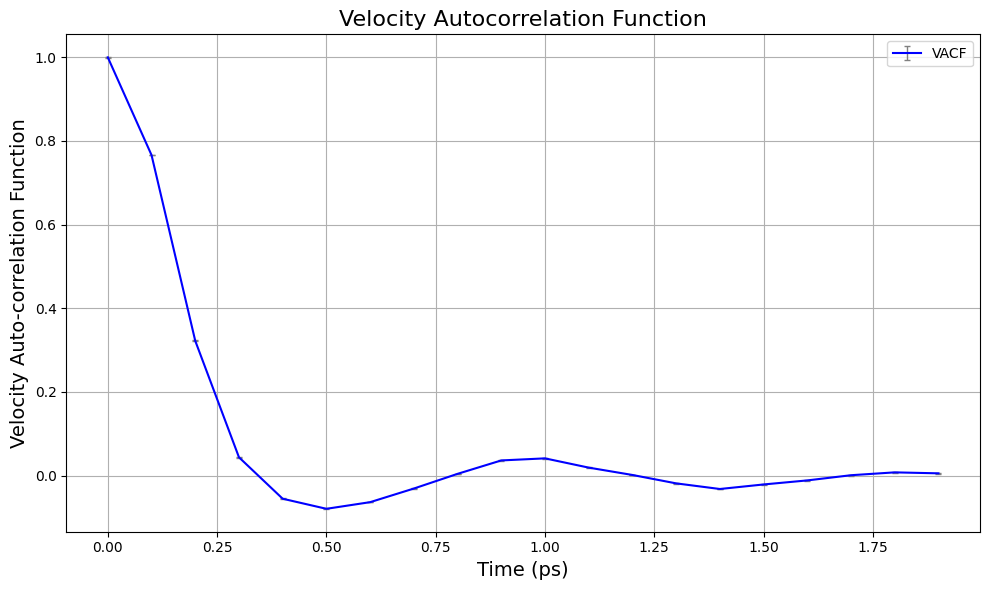

In [39]:
def calculate_velocity_correlation_normalized(v, nt):
    """
    Calculate the normalized velocity autocorrelation function (VACF) for a system of particles,
    including the standard deviation as error.

    Parameters:
    v (numpy.ndarray): Velocity array of shape (natom, 3, nt)
    nt (int): Number of time steps

    Returns:
    vacf (numpy.ndarray): Normalized velocity autocorrelation function
    vacf_std (numpy.ndarray): Standard deviation of the velocity autocorrelation function
    """
    natom = v.shape[0]
    vacf = np.zeros(nt)
    vacf_values = np.zeros((natom, nt))

    # Compute the initial velocity correlation (at t=0)
    initial_correlation = 0
    for atom in range(natom):
        initial_correlation += np.sum(v[atom, :, 0] * v[atom, :, 0])
    # Compute the velocity correlation for each time step
    for t in range(nt):
        for atom in range(natom):
            vacf_values[atom, t] = np.sum(v[atom, :, 0] * v[atom, :, t])
        vacf[t] = np.sum(vacf_values[:, t]) /(initial_correlation)

    # Calculate the standard deviation
    vacf_std = np.std(vacf_values/initial_correlation, axis=0)
    return vacf, vacf_std
ntpl = 20
vacf, vacf_std = calculate_velocity_correlation_normalized(v, ntpl)

# Plot the velocity correlation with error bars
plt.figure(figsize=(10, 6))
time_steps = np.arange(0, ntpl)  # Assuming time step is 0.5 ps
plt.errorbar(time_steps*0.1, vacf, yerr=vacf_std, fmt='b-', ecolor='gray', elinewidth=1, capsize=2, label='VACF')
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Velocity Auto-correlation Function', fontsize=14)
plt.title('Velocity Autocorrelation Function', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("vacf_with_error.pdf", format="pdf")


Velocity correlation approach 0 after a small time (around 1 ps), showing the randomness of the velocity of the system.

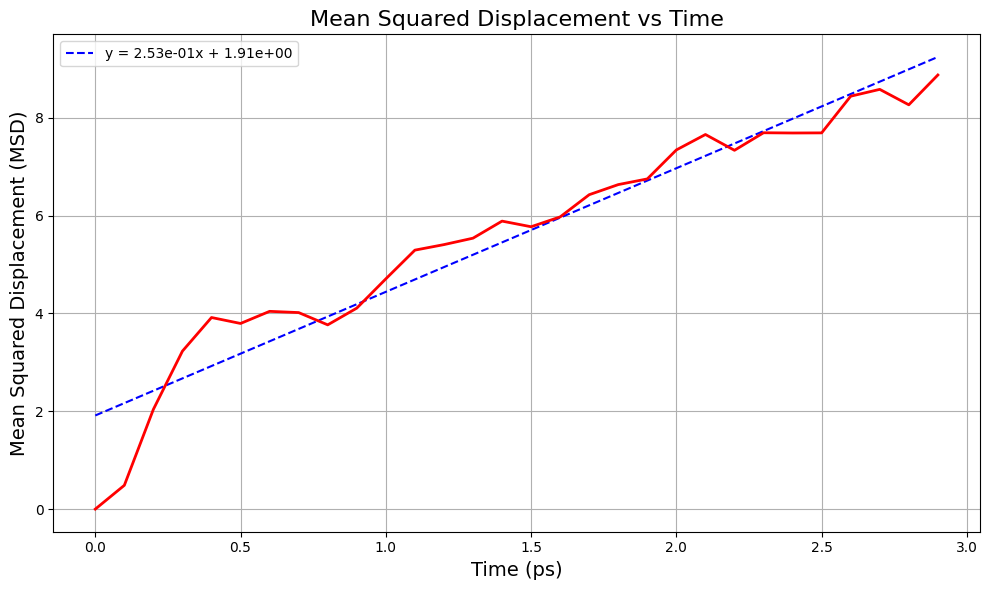

In [16]:
ntpl = 30
msd = np.zeros(ntpl)
for nts in range(ntpl):
    msd[nts] = np.mean(np.sum((x[:, :, nts] - x[:, :, 0])**2, axis=1))
fit_params = np.polyfit(np.arange(ntpl), msd, 1)
fit_line = np.polyval(fit_params, np.arange(ntpl))
plt.figure(figsize=(10, 6))
plt.plot(np.arange(ntpl)*0.1, fit_line, 'b--', label=f"y = {fit_params[0]:.2e}x + {fit_params[1]:.2e}")
plt.plot(np.arange(ntpl)*0.1, msd, 'r-', linewidth=2)
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Mean Squared Displacement (MSD)', fontsize=14)
plt.title('Mean Squared Displacement vs Time', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Convert 0.25 Å² to cm²
angstrom_to_cm = 1e-8  # 1 Å = 10^-8 cm
value_in_cm2 = 0.25 * (angstrom_to_cm ** 2)

Mean square displacement (msd) give the value of:
\begin{equation}
D = 0.25  \quad \r{A}^2 /s
\end{equation}
The best fit line for t smaller than (3 ps) is:
\begin{equation}
msd(t) = 0.25t + 1.91
\end{equation}

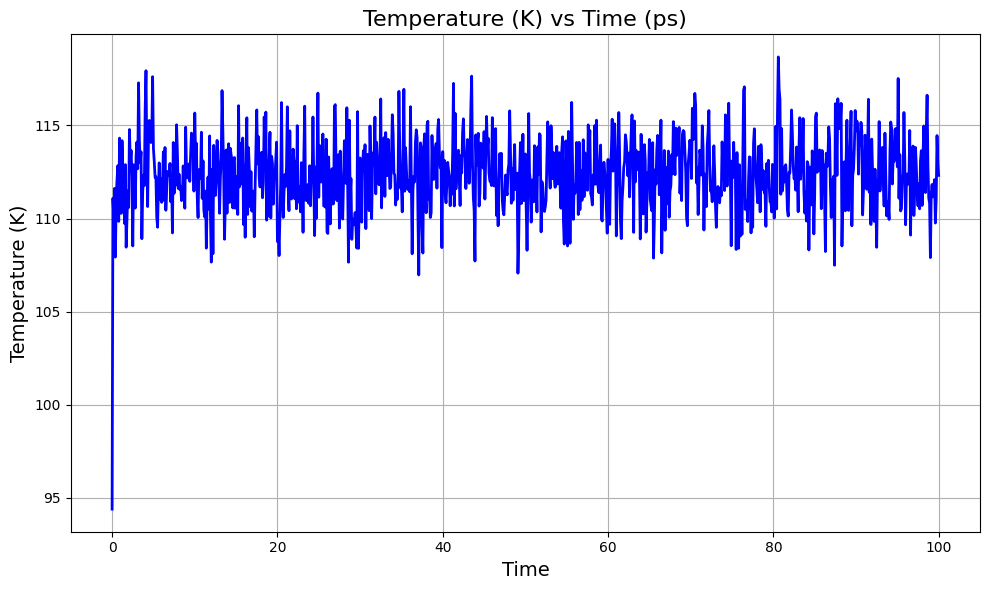

In [17]:
# Load the energy data from the file
energy_data = np.loadtxt("Energy.txt", skiprows= 1)
# Extract the 1st and 5th columns
Time = energy_data[:, 0]  # 1st column
Temperature = energy_data[:, 4]  # 5th column

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(Time, Temperature, 'b-', linewidth=2)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (K)', fontsize=14)
plt.title('Temperature (K) vs Time (ps)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

The temperature showing that the equilibrium without the thermalstat in our NVE ensemble is aroung 110 K for this set up. The combiination of kinetic and potential showing it more precisely:

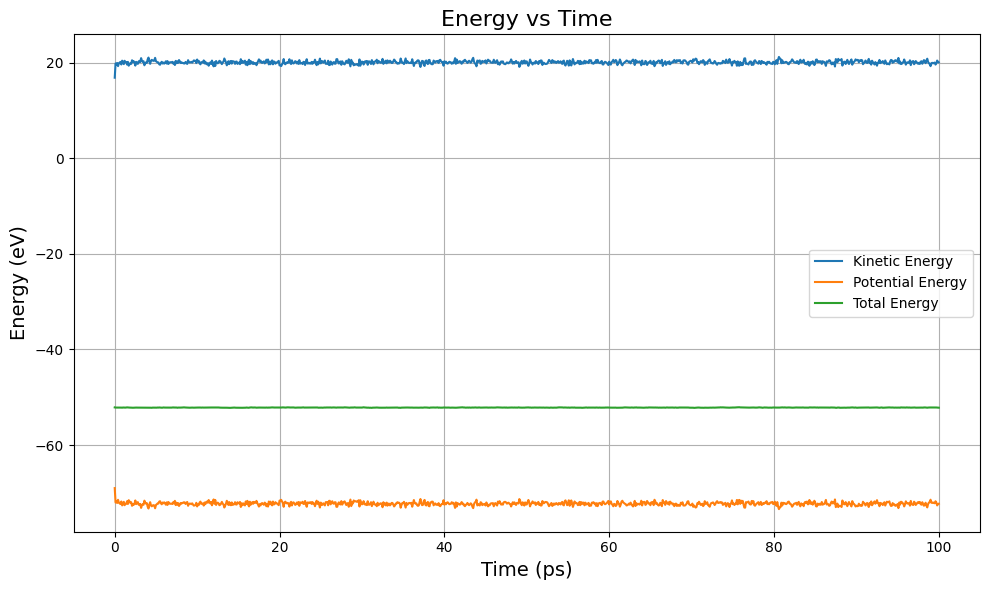

In [18]:
# Extract the specified columns
Kin = energy_data[:, 1]
Pot = energy_data[:, 2]
Tot = energy_data[:, 3]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(Time, Kin, label='Kinetic Energy')
plt.plot(Time, Pot, label='Potential Energy')
plt.plot(Time, Tot, label='Total Energy')
plt.xlabel('Time (ps)', fontsize=14)
plt.ylabel('Energy (eV)', fontsize=14)
plt.title('Energy vs Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The kinetic and potential energy exchange at the equilibrium but the total energy showing the conservation of the system